<ipython-input-11-e54f003f848d>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1, y1, z1 = row[1], row[2], row[3]
<ipython-input-11-e54f003f848d>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x2, y2, z2 = row[4], row[5], row[6]


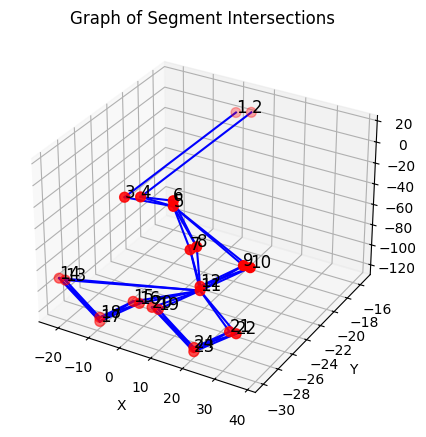

In [ ]:
import pandas as pd
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Чтение Excel-файла
df = pd.read_excel('1.xlsx')
segments = []
for idx, row in df.iterrows():
    x1, y1, z1 = row[1], row[2], row[3]
    x2, y2, z2 = row[4], row[5], row[6]
    segments.append(((x1, y1, z1), (x2, y2, z2)))

# Функция для проверки пересечения двух отрезков в 3D
def segments_intersect(P1, P2, P3, P4, tol=1e-9):
    x1,y1,z1 = P1;  x2,y2,z2 = P2
    x3,y3,z3 = P3;  x4,y4,z4 = P4
    d1 = (x2 - x1, y2 - y1, z2 - z1)
    d2 = (x4 - x3, y4 - y3, z4 - z3)
    a = d1[0]**2 + d1[1]**2 + d1[2]**2
    b = d1[0]*d2[0] + d1[1]*d2[1] + d1[2]*d2[2]
    c = d2[0]**2 + d2[1]**2 + d2[2]**2
    r = (x1 - x3, y1 - y3, z1 - z3)
    d = r[0]*d1[0] + r[1]*d1[1] + r[2]*d1[2]
    e = r[0]*d2[0] + r[1]*d2[1] + r[2]*d2[2]
    denom = b*b - a*c
    if abs(denom) < tol:
        cross_d1_d2 = (d1[1]*d2[2] - d1[2]*d2[1],
                       d1[2]*d2[0] - d1[0]*d2[2],
                       d1[0]*d2[1] - d1[1]*d2[0])
        if math.sqrt(cross_d1_d2[0]**2 + cross_d1_d2[1]**2 + cross_d1_d2[2]**2) > tol:
            return False, None
        cross_r_d1 = (r[1]*d1[2] - r[2]*d1[1],
                      r[2]*d1[0] - r[0]*d1[2],
                      r[0]*d1[1] - r[1]*d1[0])
        if math.sqrt(cross_r_d1[0]**2 + cross_r_d1[1]**2 + cross_r_d1[2]**2) > tol:
            return False, None
        if a < tol:
            # Отрезок P1P2 вырожден в точку
            if math.dist(P1, P3) < tol or math.dist(P1, P4) < tol:
                return True, P1  # точка совпадает с началом или концом другого отрезка
            return False, None
        idx = 0
        if abs(d1[1]) > abs(d1[0]): idx = 1
        if abs(d1[2]) > abs(d1[idx]): idx = 2
        def param_t(point):
            return (point[idx] - P1[idx]) / d1[idx] if abs(d1[idx]) > tol else None
        t1, t2 = 0.0, 1.0
        t3, t4 = param_t(P3), param_t(P4)
        if t3 is None or t4 is None:
            return False, None
        segA_min, segA_max = min(t1, t2), max(t1, t2)
        segB_min, segB_max = min(t3, t4), max(t3, t4)
        if segA_max < segB_min - tol or segB_max < segA_min - tol:
            return False, None
        overlap_min = max(segA_min, segB_min)
        overlap_max = min(segA_max, segB_max)
        if overlap_max - overlap_min < tol:
            inter_t = overlap_min
            inter_point = (x1 + inter_t*d1[0], y1 + inter_t*d1[1], z1 + inter_t*d1[2])
            return True, inter_point
        else:
            inter_t = overlap_min
            inter_point = (x1 + inter_t*d1[0], y1 + inter_t*d1[1], z1 + inter_t*d1[2])
            return True, inter_point
    t = (d * c - b * e) / denom
    u = (d * b - a * e) / denom
    if 0 - tol <= t <= 1 + tol and 0 - tol <= u <= 1 + tol:
        Pa = (x1 + t * d1[0], y1 + t * d1[1], z1 + t * d1[2])
        Pb = (x3 + u * d2[0], y3 + u * d2[1], z3 + u * d2[2])
        if math.dist(Pa, Pb) < tol:
            inter_point = ((Pa[0] + Pb[0]) / 2, (Pa[1] + Pb[1]) / 2, (Pa[2] + Pb[2]) / 2)
            return True, inter_point
    return False, None

# Вычисление вершин графа (середины отрезков)
vertices = [((x1+x2)/2.0, (y1+y2)/2.0, (z1+z2)/2.0) for (x1,y1,z1),(x2,y2,z2) in segments]

# Определение рёбер графа на основе пересечений
edges = []
n = len(segments)
for i in range(n):
    for j in range(i+1, n):
        intersect, _ = segments_intersect(segments[i][0], segments[i][1],
                                         segments[j][0], segments[j][1])
        if intersect:
            edges.append((i+1, j+1))
# Визуализация графа
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
Xs = [x for x,y,z in vertices]
Ys = [y for x,y,z in vertices]
Zs = [z for x,y,z in vertices]
ax.scatter(Xs, Ys, Zs, c='red', s=50)
for (v1, v2) in edges:
    i, j = v1-1, v2-1
    ax.plot([vertices[i][0], vertices[j][0]],
            [vertices[i][1], vertices[j][1]],
            [vertices[i][2], vertices[j][2]], c='blue')
for idx, (x,y,z) in enumerate(vertices, start=1):
    ax.text(x, y, z, str(idx), color='black', fontsize=12)
ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
ax.set_title('Graph of Segment Intersections')
plt.show()

# Сохранение таблиц вершин и рёбер в Excel
vertices_df = pd.DataFrame({
    'Vertex': range(1, len(vertices)+1),
    'X': [x for x,y,z in vertices],
    'Y': [y for x,y,z in vertices],
    'Z': [z for x,y,z in vertices]
})
edges_df = pd.DataFrame(edges, columns=['Vertex_A', 'Vertex_B'])
with pd.ExcelWriter('graph_output.xlsx') as writer:
    vertices_df.to_excel(writer, sheet_name='Vertices', index=False)
    edges_df.to_excel(writer, sheet_name='Edges', index=False)

In [ ]:
from google.colab import files
files.download('graph_output.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>